In [2]:
import scipy.optimize as sco
import scipy.stats as scs
import scipy.interpolate as sci
import statsmodels.api as sm
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA

%matplotlib inline

In [9]:
# the DAX index
symbols = ['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE',
    'BMW.DE', 'CBK.DE', 'CON.DE', 'DAI.DE', 'DB1.DE',
    'DBK.DE', 'DPW.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE',
    'FRE.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'LHA.DE',
    'LIN.DE', 'LXS.DE', 'MRK.DE', 'MUV2.DE', 'RWE.DE',
    'SAP.DE', 'SDF.DE', 'SIE.DE', 'TKA.DE', 'VOW3.DE',
    '^GDAXI']

In [52]:
fin_data = pd.DataFrame()
for sym in symbols:
    fin_data[sym] = data.DataReader(sym, data_source='yahoo')['Close']
#fin_data.symbols = symbols

In [53]:
fin_data = fin_data.dropna()
dax = pd.DataFrame(fin_data.pop('^GDAXI'))

In [54]:
fin_data = fin_data.dropna()
fin_data[fin_data.columns[:6]].head()

,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE
Date,,,,,,
2010-01-04,38.505001,88.540001,44.849998,56.400002,46.445000,32.049999
2010-01-05,39.720001,88.809998,44.169998,55.369999,46.200001,32.310001
2010-01-06,39.400002,89.500000,44.450001,55.020000,46.165001,32.810001
2010-01-07,39.744999,88.470001,44.154999,54.299999,45.700001,33.099998
2010-01-08,39.599998,87.989998,44.020000,53.820000,44.380001,32.654999


In [55]:
scale_function = lambda x : (x - x.mean())/x.std()

In [56]:
pca = KernelPCA().fit(fin_data.apply(scale_function))

In [57]:
# look at first 10 components, by 10th its effect is almost negligible
pca.lambdas_[:10].round()

array([ 36999.,   4857.,   3643.,   2187.,   1347.,    584.,    436.,
          241.,    167.,    155.])

In [58]:
# normalise, can see first component has 73% of the variability
get_we = lambda x: x/x.sum()
get_we(pca.lambdas_[:10])

array([ 0.7309767 ,  0.09595988,  0.07197785,  0.04320178,  0.02661634,
        0.01152923,  0.00861683,  0.00475627,  0.00329962,  0.00306548])

In [59]:
# first 5 components have 95% of the variability
get_we(pca.lambdas_)[:5].sum()

0.95582312950984694

Let's construct a PCA index

In [60]:
pca = KernelPCA(n_components=1).fit(fin_data.apply(scale_function))
dax['PCA_1'] = pca.transform(-fin_data)

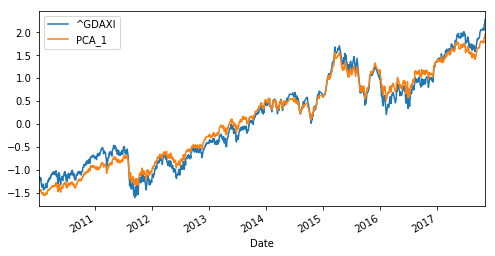

In [61]:
dax.apply(scale_function).plot(figsize=(8,4))

In [65]:
pca = KernelPCA(n_components=5).fit(fin_data.apply(scale_function))
pca_components = pca.transform(-fin_data)
weights = get_we(pca.lambdas_)
dax['PCA_5'] = np.dot(pca_components,weights)

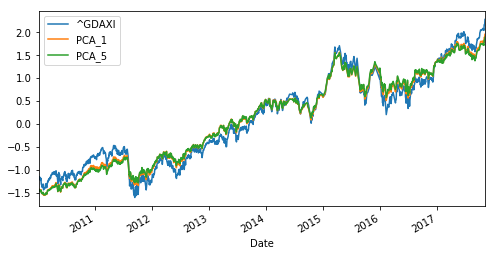

In [66]:
dax.apply(scale_function).plot(figsize=(8,4))

In [80]:
# convert dates in matplot dates
import matplotlib as mpl
mpl_dates = mpl.dates.date2num(np.array([x.date() for x in fin_data.index]))

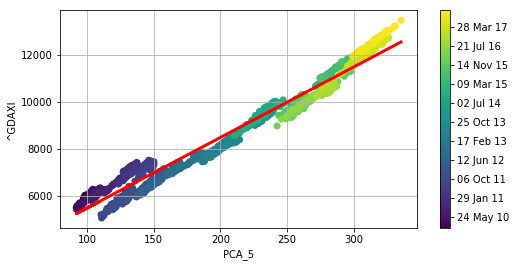

In [81]:
plt.figure(figsize=(8, 4))
plt.scatter(dax['PCA_5'], dax['^GDAXI'], c=mpl_dates)
lin_reg = np.polyval(np.polyfit(dax['PCA_5'], dax['^GDAXI'], 1), dax['PCA_5'])
plt.plot(dax['PCA_5'], lin_reg, 'r', lw=3)
plt.grid(True)
plt.xlabel('PCA_5')
plt.ylabel('^GDAXI')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),format=mpl.dates.DateFormatter('%d %b %y'))